In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install squarify

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify
from datetime import datetime

In [ ]:
transaction = pd.read_csv('/content/drive/MyDrive/DL07_K302_ToNguyenPhuongAnh/Project1/Transactions.csv', header=0)
product = pd.read_csv('/content/drive/MyDrive/DL07_K302_ToNguyenPhuongAnh/Project1/Products_with_Categories.csv', header=0)

In [ ]:
# merge 2 bảng dữ liệu
df = transaction.merge(product, on="productId", how='left')
df['Revenue'] = df['items'] * df['price']

In [ ]:
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y').date()).astype('datetime64[ns]')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Member_number  38765 non-null  int64         
 1   Date           38765 non-null  datetime64[ns]
 2   productId      38765 non-null  int64         
 3   items          38765 non-null  int64         
 4   productName    38765 non-null  object        
 5   price          38765 non-null  float64       
 6   Category       38765 non-null  object        
 7   Revenue        38765 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 2.4+ MB


In [ ]:
print(f'Transaction timeframe from {df["Date"].min()} to {df["Date"].max()}')
print(f'{len(transaction.Member_number.unique())} unique customer')

Transaction timeframe from 2014-01-01 00:00:00 to 2015-12-30 00:00:00
3898 unique customer


In [ ]:
# tạo cột order_id
df['order_id'] = df.groupby(['Date', 'Member_number']).ngroup()

### Create RFM analysis for each customers

In [ ]:
max_date = df['Date'].max().date()

Recency = lambda x : (max_date - x.max().date()).days
Frequency  = lambda x: len(x.unique())
Monetary = lambda x : round(sum(x), 2)

df_RFM = df.groupby('Member_number').agg({'Date': Recency,
                                        'order_id': Frequency,
                                        'Revenue': Monetary })
df_RFM.columns = ['Recency', 'Frequency', 'Monetary']
df_RFM = df_RFM.sort_values('Monetary', ascending=False)
df_RFM.head()

,Recency,Frequency,Monetary
Member_number,,,
2433,3,7,375.31
2193,91,11,361.45
1793,26,10,345.10
3289,4,10,334.15
2743,142,7,312.46


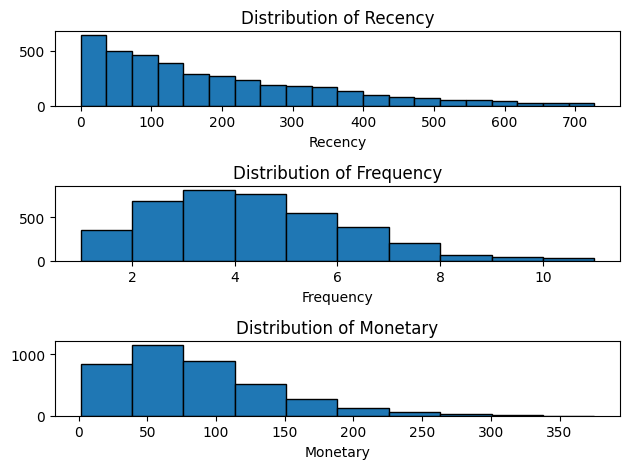

In [ ]:
# Vẽ phân phối của 'Recency'
plt.subplot(3, 1, 1) # 3 hàng, 1 cột, vị trí thứ nhất
plt.hist(df_RFM['Recency'], bins=20, edgecolor='black')
plt.title('Distribution of Recency')
plt.xlabel('Recency')

plt.subplot(3, 1, 2)
plt.hist(df_RFM['Frequency'], bins=10, edgecolor='black')
plt.title('Distribution of Frequency')
plt.xlabel('Frequency')

plt.subplot(3, 1, 3)
plt.hist(df_RFM['Monetary'], bins=10, edgecolor='black')
plt.title('Distribution of Monetary')
plt.xlabel('Monetary')

plt.tight_layout()
plt.show()

#### Nhận xét:
1. Phân phối Recency (R)
- Khoảng giá trị: 0–700 ngày (trục x), nhưng phần lớn tập trung ở dưới 500 ngày.

- Đặc điểm nổi bật:
  - Peak rõ rệt ở khoảng 100–300 ngày → Nhiều khách hàng có lần mua gần đây trong 3–10 tháng.

  - Đuôi dài đến 700 ngày → Một số ít khách rất lâu không mua (trên 1.5 năm).

2. Phân phối Frequency (F)
- Khoảng giá trị: 0–10 đơn (trục x), tập trung ở 2–6 đơn.

- Đặc điểm nổi bật:

  - Phân phối lệch phải → Đa số khách mua 2–4 đơn, rất ít khách mua >8 đơn.

  - Đỉnh ở khoảng 3–4 đơn → Đây là tần suất phổ biến nhất.

3. Phân phối Monetary (M)
- Khoảng giá trị: tập trung ở khoảng 50-150

- Điểm nổi bật:

  - Phân phối chuẩn với đỉnh khoảng 100–150$ → Giá trị đơn hàng trung bình của cửa hàng.

  - Outlier ở 250–350$ → Một số ít khách chi tiêu cao (VIP tiềm năng).

/usr/local/lib/python3.11/dist-packages/seaborn/_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
/usr/local/lib/python3.11/dist-packages/seaborn/_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
/usr/local/lib/python3.11/dist-packages/seaborn/_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


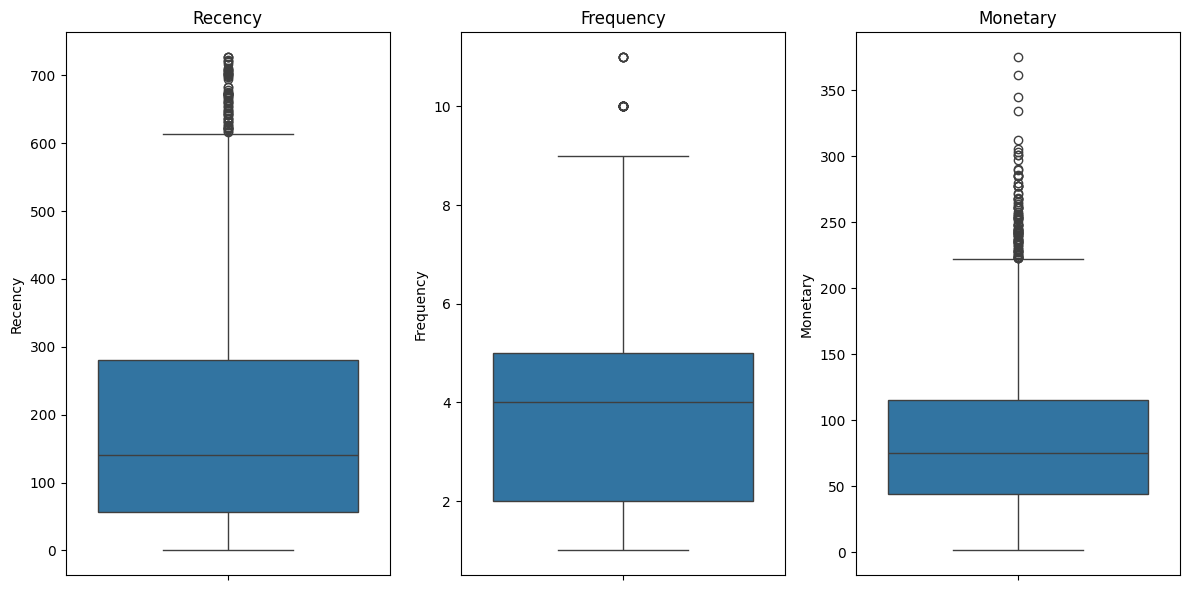

In [ ]:
# Vẽ boxplot
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.boxplot(y=df_RFM['Recency'], orient='h').set_title('Recency')
plt.subplot(1, 3, 2)
sns.boxplot(y=df_RFM['Frequency'], orient='h').set_title('Frequency')
plt.subplot(1, 3, 3)
sns.boxplot(y=df_RFM['Monetary'], orient='h').set_title('Monetary')

plt.tight_layout()
plt.show()

- Xuất hiện nhiều outliers, đặc biệt là Recency và Monetary
- Frequency có ít outliers hơn nhưng vẫn có

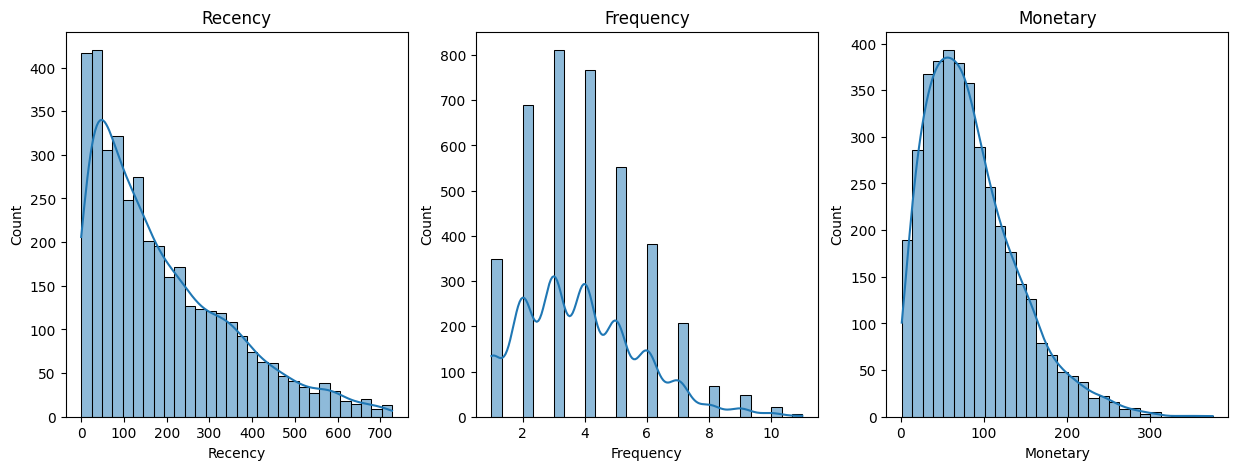

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(["Recency", "Frequency", "Monetary"]):
    sns.histplot(df_RFM[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(col)

plt.show()

- Cả 3 đều là right-skewed

### Calculate RFM quartiles

In [ ]:
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)
[*r_labels]

[4, 3, 2, 1]

In [ ]:
# Assign these labels to 4 equal percentile groups
r_groups = pd.qcut(df_RFM['Recency'].rank(method='first'), q=4, labels=r_labels)

f_groups = pd.qcut(df_RFM['Frequency'].rank(method='first'), q=4, labels=f_labels)

m_groups = pd.qcut(df_RFM['Monetary'].rank(method='first'), q=4, labels=m_labels)

In [ ]:
# Create new columns R, F, M
df_RFM = df_RFM.assign(R = r_groups.values, F = f_groups.values,  M = m_groups.values)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M
Member_number,,,,,,
2433,3,7,375.31,4,4,4
2193,91,11,361.45,3,4,4
1793,26,10,345.10,4,4,4
3289,4,10,334.15,4,4,4
2743,142,7,312.46,2,4,4


### Concat RFM quartile values to create RFM segments

In [ ]:
def join_rfm(x): return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))
df_RFM['RFM_Segment'] = df_RFM.apply(join_rfm, axis=1)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment
Member_number,,,,,,,
2433,3,7,375.31,4,4,4,444
2193,91,11,361.45,3,4,4,344
1793,26,10,345.10,4,4,4,444
3289,4,10,334.15,4,4,4,444
2743,142,7,312.46,2,4,4,244


In [ ]:
# Count num of unique segments
rfm_count_unique = df_RFM.groupby('RFM_Segment')['RFM_Segment'].nunique()
rfm_count_unique.sum()

np.int64(63)

Having 63 different segments using the concatenate method quickly becomes unwieldy for any practical use. We will need a more concise way to define our segments.

### Calculate RFM score and level

In [ ]:
df_RFM['RFM_Score'] = df_RFM[['R','F', 'M']].sum(axis=1)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
Member_number,,,,,,,,
2433,3,7,375.31,4,4,4,444,12
2193,91,11,361.45,3,4,4,344,11
1793,26,10,345.10,4,4,4,444,12
3289,4,10,334.15,4,4,4,444,12
2743,142,7,312.46,2,4,4,244,10


In [ ]:
df_RFM['RFM_Score'].unique()

array([12, 11, 10,  9,  8,  7,  6,  5,  4,  3])

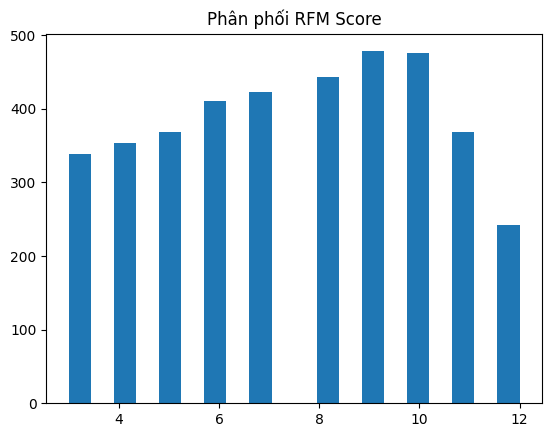

In [ ]:
plt.hist(df_RFM['RFM_Score'], bins=20)
plt.title('Phân phối RFM Score')
plt.show()

In [ ]:
def rfm_level(df):
    # 1. VIP (R+F+M cao nhất, hoạt động gần đây)
    if (df['RFM_Score'] >= 11) or ((df['R'] >= 4) and (df['F'] >= 4) and (df['M'] >= 3)):
        return "VIP"

    # 2. Loyal (F cao, R trung bình/cao)
    elif (df['F'] >= 4) and (df['R'] >= 3):
        return "Loyal"

    # 3. New (R rất cao, F thấp, mới mua gần đây)
    elif (df['R'] == 4) and (df['F'] <= 2) and (df['Recency'] <= 90):  # ≤ Q1 của Recency
        return "New"

    # 4. At Risk (R thấp, F trung bình/cao)
    elif (df['R'] <= 2) and (df['F'] >= 3):
        return "At Risk"

    # 5. Dormant (R thấp, F thấp)
    else:
        return "Dormant"

In [ ]:
# Create a new column RFM_Level
df_RFM['RFM_Level'] = df_RFM.apply(rfm_level, axis=1)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
Member_number,,,,,,,,,
2433,3,7,375.31,4,4,4,444,12,VIP
2193,91,11,361.45,3,4,4,344,11,VIP
1793,26,10,345.10,4,4,4,444,12,VIP
3289,4,10,334.15,4,4,4,444,12,VIP
2743,142,7,312.46,2,4,4,244,10,At Risk


In [ ]:
# Number of segments
df_RFM['RFM_Level'].value_counts()

,count
RFM_Level,
Dormant,2123
At Risk,688
VIP,610
New,292
Loyal,185


In [ ]:
df_RFM.to_csv('/content/drive/MyDrive/DL07_K302_ToNguyenPhuongAnh/Project1/RFM.csv', index=False)

In [ ]:
# Calculate mean values for each segment
rfm_agg = df_RFM.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(0)

rfm_agg.columns = rfm_agg.columns.droplevel()
rfm_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg['Percent'] = round((rfm_agg['Count'] / rfm_agg['Count'].sum()) * 100, 2)

rfm_agg = rfm_agg.reset_index()
rfm_agg

,RFM_Level,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,At Risk,257.0,5.0,102.0,688,17.65
1,Dormant,237.0,3.0,62.0,2123,54.46
2,Loyal,81.0,6.0,78.0,185,4.75
3,New,27.0,3.0,66.0,292,7.49
4,VIP,47.0,6.0,158.0,610,15.65


### Tree map

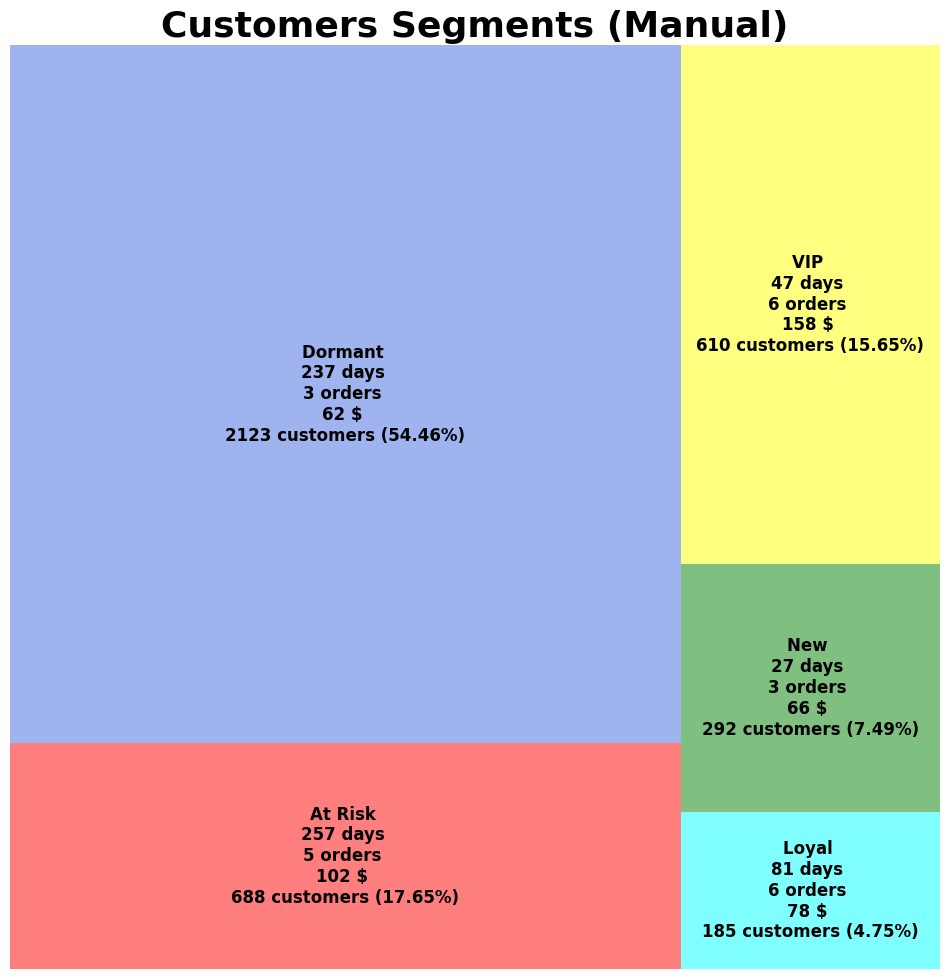

In [ ]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(12, 12)

colors_dict = {'VIP':'yellow','Dormant':'royalblue', 'Loyal':'cyan', 'At Risk':'red', 'New': 'green'}

squarify.plot(sizes=rfm_agg['Count'],
              text_kwargs={'fontsize':12, 'weight':'bold', 'fontname':"sans serif"},
              color=[colors_dict[cluster] for cluster in rfm_agg['RFM_Level']],
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg.iloc[i])
                      for i in range(len(rfm_agg))], alpha=0.5)

plt.title("Customers Segments (Manual)",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('RFM Segments.png')
plt.show()

In [ ]:
# RFM Scatter Plot
fig = px.scatter(rfm_agg, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="RFM_Level",
           hover_name="RFM_Level", size_max=100)
fig.show()

## RFM + KMeans

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

In [ ]:
rfm_data = df_RFM[['Recency', 'Frequency', 'Monetary']]

In [ ]:
# Chuẩn hoá dữ liệu
scaler = RobustScaler()
rfm_scaled = scaler.fit_transform(rfm_data)

# Elbow Method để chọn số cụm
sse = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_

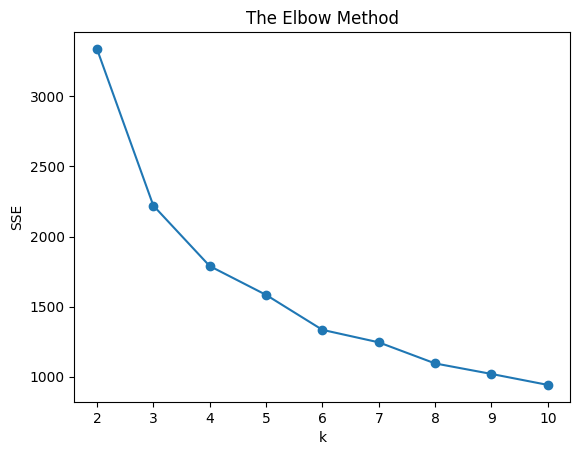

In [ ]:
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')

plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.show()

In [ ]:
# Build model with k=3
model = KMeans(n_clusters=4, random_state=42)
model.fit(rfm_scaled)
model.labels_.shape

(3898,)

In [ ]:
rfm_data["Cluster"] = model.labels_
rfm_data.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

<ipython-input-361-f07215fb31f4>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0        119.39      4.89   109.67  1252
1        427.46      2.33    44.52   889
2         89.15      6.81   193.53   460
3        124.26      2.81    51.08  1297

In [ ]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg2 = rfm_data.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg2.columns = rfm_agg2.columns.droplevel()
rfm_agg2.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg2['Percent'] = round((rfm_agg2['Count']/rfm_agg2.Count.sum())*100, 2)

# Reset the index
rfm_agg2 = rfm_agg2.reset_index()

# Change thr Cluster Columns Datatype into discrete values
rfm_agg2['Cluster'] = 'Cluster '+ rfm_agg2['Cluster'].astype('str')

# Print the aggregated dataset
rfm_agg2

,Cluster,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,Cluster 0,119.0,5.0,110.0,1252,32.12
1,Cluster 1,427.0,2.0,45.0,889,22.81
2,Cluster 2,89.0,7.0,194.0,460,11.80
3,Cluster 3,124.0,3.0,51.0,1297,33.27


In [ ]:
# Tạo dictionary để đổi tên cluster
cluster_names = {
    'Cluster 0': "Loyal",
    'Cluster 1': "Dormant",
    'Cluster 2': "VIP",
    'Cluster 3': "At Risk"
}

# Đổi tên cluster trong cột 'Cluster'
rfm_agg2['Cluster'] = rfm_agg2['Cluster'].map(cluster_names)

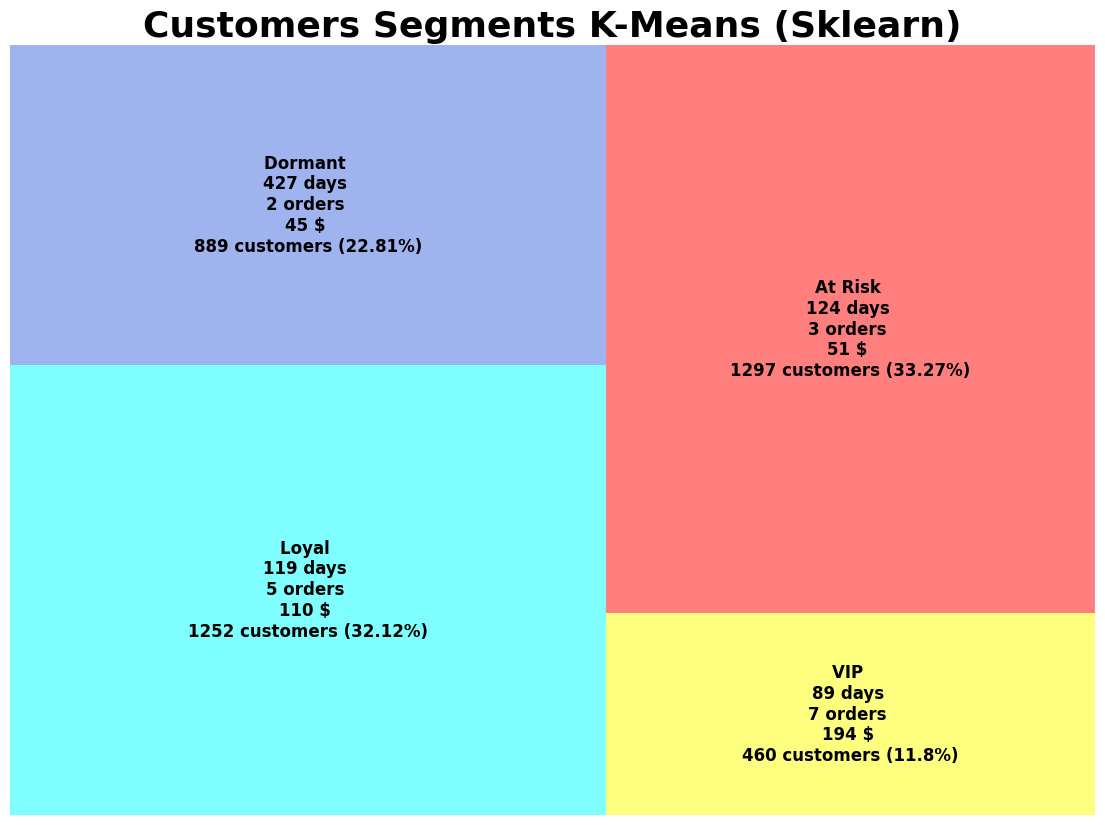

In [ ]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'VIP':'yellow','Dormant':'royalblue', 'Loyal':'cyan', 'At Risk':'red'}

squarify.plot(sizes=rfm_agg2['Count'],
              text_kwargs={'fontsize':12, 'weight':'bold', 'fontname':"sans serif"},
              color=[colors_dict2[cluster] for cluster in rfm_agg2['Cluster']],
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg2.iloc[i])
                      for i in range(len(rfm_agg2))], alpha=0.5)


plt.title("Customers Segments K-Means (Sklearn)",fontsize=26,fontweight="bold")
plt.axis('off')
plt.show()

In [ ]:
import plotly.express as px

fig = px.scatter(rfm_agg2, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
           hover_name="Cluster", size_max=100)
fig.show()

#### Summary
- VIP (11.8%):

  - Recency thấp (89 ngày), Frequency cao (7 orders), Monetary cao nhất (194$).

- Loyal (32.12%):

  - Recency trung bình (119 ngày), Frequency cao (5 orders), Monetary khá (110$).

- At Risk (33.27%):

  - Recency cao (124 ngày), Frequency trung bình (3 orders), Monetary thấp (51$).

- Dormant (22.81%):

  - Recency rất cao (427 ngày), Frequency thấp (2 orders), Monetary thấp nhất (45$).
→ Nhóm "ngủ đông", khó đánh thức. Cần chiến dịch mạnh

## RFM + Hierachical Clustering

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import RobustScaler

In [ ]:
rfm_data_2 = df_RFM[['Recency', 'Frequency', 'Monetary']]
scaler = RobustScaler()
rfm_scaled_2 = scaler.fit_transform(rfm_data_2)

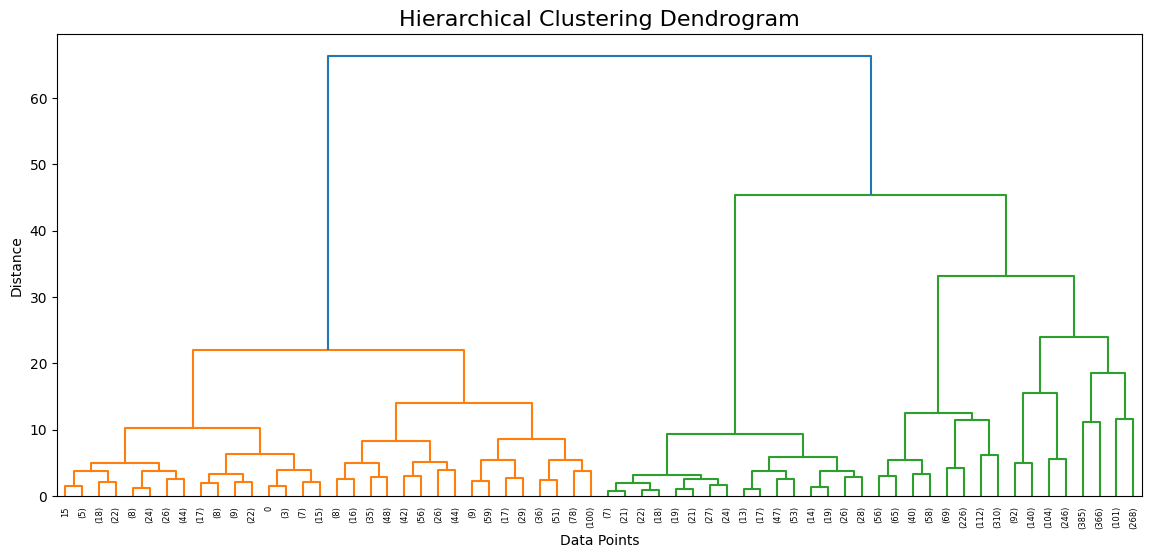

In [ ]:
linkage_matrix = linkage(rfm_scaled_2, method='ward')

# Vẽ Dendrogram để xác định số cụm phù hợp
plt.figure(figsize=(14, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram', fontsize=16)
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.savefig('/content/drive/MyDrive/DL07_K302_ToNguyenPhuongAnh/Project1/Hierachical.png')
plt.show()

In [ ]:
n_clusters = 4
rfm_data['Cluster'] = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

<ipython-input-355-c1584c11331f>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
rfm_agg3 = rfm_data.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg3.columns = rfm_agg3.columns.droplevel()
rfm_agg3.columns = ['RecencyMean', 'FrequencyMean', 'MonetaryMean', 'Count']
rfm_agg3['Percent'] = round((rfm_agg3['Count'] / rfm_agg3['Count'].sum()) * 100, 2)

rfm_agg3 = rfm_agg3.reset_index()
rfm_agg3['Cluster'] = 'Cluster ' + rfm_agg3['Cluster'].astype(str)

In [ ]:
rfm_agg3

,Cluster,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,Cluster 1,107.0,6.0,163.0,884,22.68
1,Cluster 2,521.0,2.0,28.0,376,9.65
2,Cluster 3,65.0,4.0,89.0,936,24.01
3,Cluster 4,223.0,3.0,56.0,1702,43.66


In [ ]:
# Tạo dictionary để đổi tên cluster
cluster_names_2 = {
    'Cluster 1': "VIP",
    'Cluster 2': "Dormant",
    'Cluster 3': "Loyal",
    'Cluster 4': "At Risk"
}

# Đổi tên cluster trong cột 'Cluster'
rfm_agg3['Cluster'] = rfm_agg3['Cluster'].map(cluster_names_2)

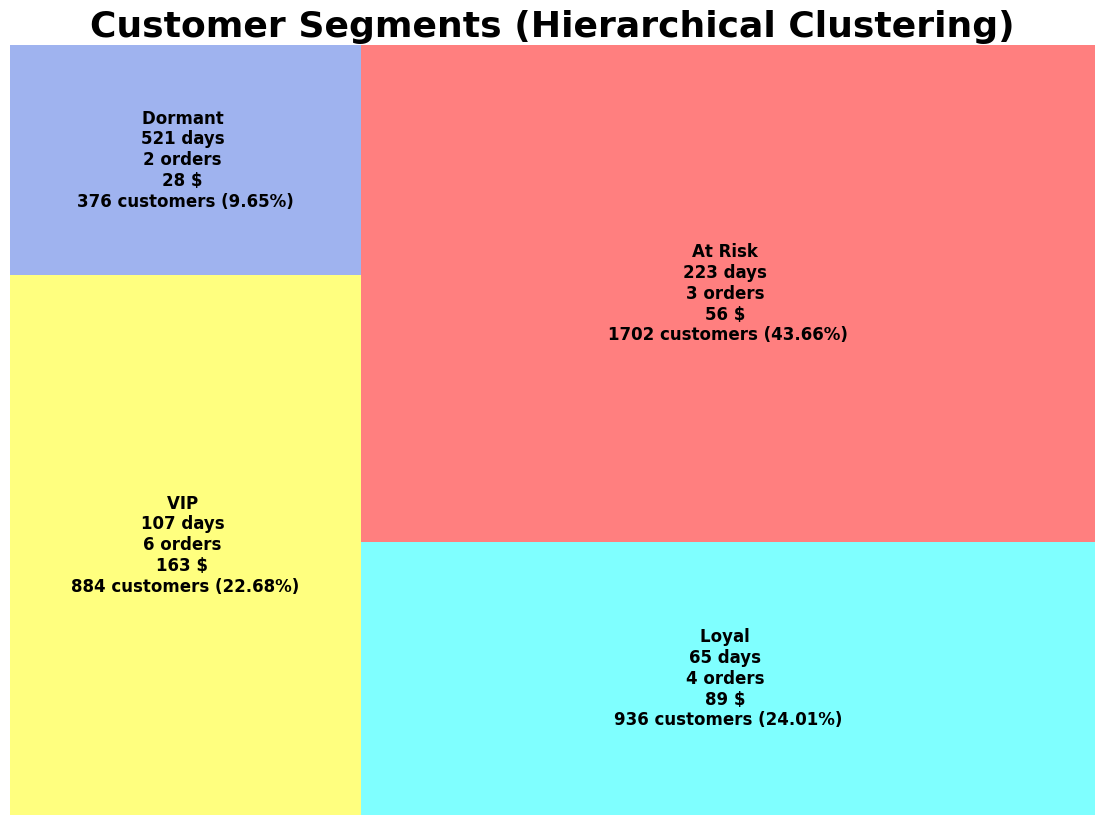

In [ ]:
# 🎨 Vẽ Tree Map
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'VIP':'yellow','Dormant':'royalblue', 'Loyal':'cyan', 'At Risk':'red'}

squarify.plot(sizes=rfm_agg3['Count'],
              text_kwargs={'fontsize':12, 'weight':'bold', 'fontname':"sans serif"},
              color=[colors_dict2[cluster] for cluster in rfm_agg3['Cluster']],
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg3.iloc[i])
                      for i in range(len(rfm_agg3))], alpha=0.5)

plt.title("Customer Segments (Hierarchical Clustering)", fontsize=26, fontweight="bold")
plt.axis('off')
plt.savefig('/content/drive/MyDrive/DL07_K302_ToNguyenPhuongAnh/Project1/Hierarchical_tree.png')
plt.show()

In [ ]:
# 📈 Vẽ Scatter Plot
fig = px.scatter(rfm_agg3, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
                 hover_name="Cluster", size_max=100)
fig.show()

#### Summary
- VIP (22.68%):

  - Recency tốt (107 ngày), Frequency cao (6 orders), Monetary cao nhất (163$).
→ Nhóm khách hàng giá trị, nhưng Recency cao hơn so với K-Means Sklearn (89 ngày). Cần theo dõi xu hướng để đảm bảo họ không giảm tương tác.

- Loyal (24.01%):

  - Recency rất tốt (65 ngày), Frequency khá (4 orders), Monetary trung bình (89$).
→ Nhóm trung thành với tiềm năng tăng giá trị đơn hàng.

- At Risk (43.66%):

  - Recency cao (223 ngày), Frequency trung bình (3 orders), Monetary thấp (56$).
→ Chiếm tỷ lệ lớn nhất, nguy cơ rời bỏ cao. Ưu tiên chiến dịch win-back mạnh.

- Dormant (9.65%):

  - Recency rất cao (521 ngày), Frequency thấp (2 orders), Monetary thấp nhất (28$).
→ Nhóm khó đánh thức, nhưng tỷ lệ nhỏ. Có thể tập trung vào nhóm At Risk trước.

## RFM + KMeans (Pyspark)

In [ ]:
!apt update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar -xvf spark-3.3.0-bin-hadoop3.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 257 kB in 1s (194 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
40 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as reposito

In [ ]:
import findspark
findspark.init()

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('segmentation').getOrCreate()

In [ ]:
data = spark.read.csv('/content/drive/MyDrive/DL07_K302_ToNguyenPhuongAnh/Project1/RFM.csv', header=True, inferSchema=True)
data.count()

3898

In [ ]:
df_now = data.select('Recency','Frequency','Monetary')
df_now.head()

Row(Recency=3, Frequency=7, Monetary=375.31)

In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import RobustScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:
assembler = VectorAssembler(inputCols=df_now.columns,
                            outputCol="features")
df_final = assembler.transform(df_now)

scaler = RobustScaler(inputCol='features', outputCol='scaledFeatures')
df_final = scaler.fit(df_final).transform(df_final)

In [ ]:
# Build model - choose k by silhouette
k_list = []
silhouette_list = []
sil_str = ""
for k in range(2,11):
    kmeans = KMeans(featuresCol="scaledFeatures", k=k)
    model = kmeans.fit(df_final)
    k_list.append(k)
    # silhouette
    predictions = model.transform(df_final)
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_list.append(silhouette)
    sil_str = sil_str + "With k =" + str(k) + "- Silhouette = " + str(silhouette) + "\n"

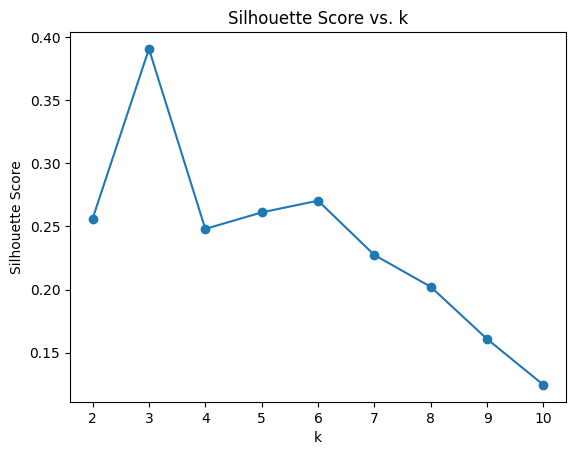

In [ ]:
plt.plot(k_list, silhouette_list, marker='o')
plt.title('Silhouette Score vs. k')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.savefig('/content/drive/MyDrive/DL07_K302_ToNguyenPhuongAnh/Project1/silhouette.png')
plt.show()

In [ ]:
# Train a k-means model
kmeans = KMeans(featuresCol='scaledFeatures', k=4)
model = kmeans.fit(df_final)
predictions = model.transform(df_final)

In [ ]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhoutte = " + str(silhouette))

Silhoutte = 0.24804518199019363


In [ ]:
# Shows result result
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center) # in ra k cluster center

Cluster Centers: 
[0.83135044 0.81752484 0.62586798]
[0.47981492 2.10771841 2.38373568]
[2.11711661 0.74570983 0.58987642]
[0.45929277 1.42815249 1.25185687]


In [ ]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  745|
|         3| 1391|
|         2|  694|
|         0| 1068|
+----------+-----+



In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, sum as Fsum, round as Fround, concat, lit

rfm_agg4 = predictions.groupBy('prediction').agg(
    F.round(F.mean('Recency'), 2).alias('RecencyMean'),
    F.round(F.mean('Frequency'), 2).alias('FrequencyMean'),
    F.round(F.mean('Monetary'), 2).alias('MonetaryMean'),
    F.count('Monetary').alias('Count')
)
rfm_agg4.show()

+----------+-----------+-------------+------------+-----+
|prediction|RecencyMean|FrequencyMean|MonetaryMean|Count|
+----------+-----------+-------------+------------+-----+
|         1|     105.79|         6.38|      172.54|  745|
|         3|     106.48|         4.34|       91.24| 1391|
|         2|     462.18|         2.28|       43.63|  694|
|         0|     172.26|         2.43|       43.46| 1068|
+----------+-----------+-------------+------------+-----+



In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, sum as Fsum, round as Fround, concat, lit

rfm_agg4 = predictions.groupBy('prediction').agg(
    F.round(F.mean('Recency'), 2).alias('RecencyMean'),
    F.round(F.mean('Frequency'), 2).alias('FrequencyMean'),
    F.round(F.mean('Monetary'), 2).alias('MonetaryMean'),
    F.count('Monetary').alias('Count')
)

rfm_agg4 = rfm_agg4.withColumnRenamed("prediction", "Cluster")

total_count = rfm_agg4.agg(Fsum(col("Count")).alias("total")).collect()[0]["total"]
rfm_agg4 = rfm_agg4.withColumn("Percent", Fround((col("Count") / total_count) * 100, 2))
rfm_agg4 = rfm_agg4.withColumn("Cluster", concat(lit("Cluster "), col("Cluster").cast("string")))

In [ ]:
rfm_agg4.show()

+---------+-----------+-------------+------------+-----+-------+
|  Cluster|RecencyMean|FrequencyMean|MonetaryMean|Count|Percent|
+---------+-----------+-------------+------------+-----+-------+
|Cluster 1|     105.79|         6.38|      172.54|  745|  19.11|
|Cluster 3|     106.48|         4.34|       91.24| 1391|  35.68|
|Cluster 2|     462.18|         2.28|       43.63|  694|   17.8|
|Cluster 0|     172.26|         2.43|       43.46| 1068|   27.4|
+---------+-----------+-------------+------------+-----+-------+



In [ ]:
from pyspark.sql.functions import when, col
# Đổi tên cluster
rfm_agg4 = rfm_agg4.withColumn(
    'Cluster',
    when(col('Cluster') == 'Cluster 0', 'At Risk')
    .when(col('Cluster') == 'Cluster 1', 'VIP')
    .when(col('Cluster') == 'Cluster 2', 'Dormant')
    .when(col('Cluster') == 'Cluster 3', 'Loyal')
    .otherwise(col('Cluster'))  # Giữ nguyên nếu không khớp
)

In [ ]:
rfm_agg4.show()

+-------+-----------+-------------+------------+-----+-------+
|Cluster|RecencyMean|FrequencyMean|MonetaryMean|Count|Percent|
+-------+-----------+-------------+------------+-----+-------+
|    VIP|     105.79|         6.38|      172.54|  745|  19.11|
|  Loyal|     106.48|         4.34|       91.24| 1391|  35.68|
|Dormant|     462.18|         2.28|       43.63|  694|   17.8|
|At Risk|     172.26|         2.43|       43.46| 1068|   27.4|
+-------+-----------+-------------+------------+-----+-------+



In [ ]:
rfm_agg4_pandas = rfm_agg4.toPandas()

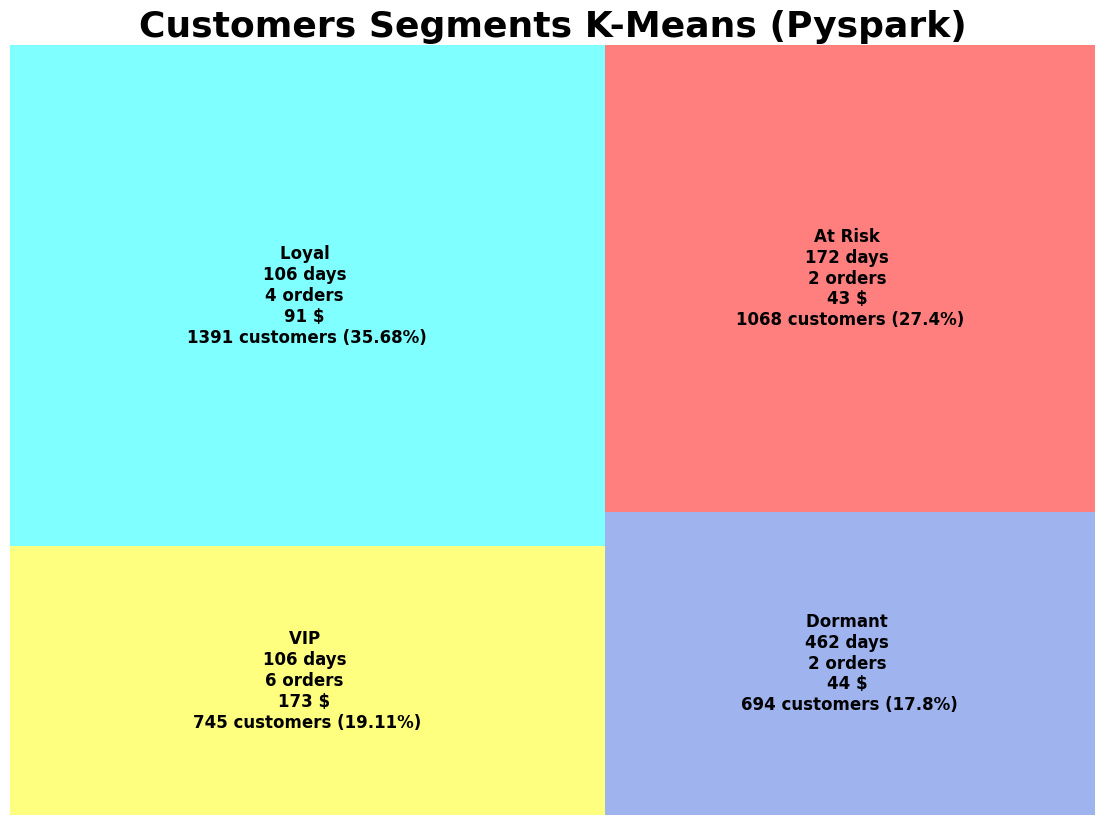

In [ ]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'VIP':'yellow','Dormant':'royalblue', 'Loyal':'cyan', 'At Risk':'red'}

squarify.plot(sizes=rfm_agg4_pandas['Count'],
              text_kwargs={'fontsize':12, 'weight':'bold', 'fontname':"sans serif"},
              color=[colors_dict2[cluster] for cluster in rfm_agg4_pandas['Cluster']],
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg4_pandas.iloc[i])
                      for i in range(len(rfm_agg4_pandas))], alpha=0.5)

plt.title("Customers Segments K-Means (Pyspark)",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('/content/drive/MyDrive/DL07_K302_ToNguyenPhuongAnh/Project1/Kmeans-pyspark.png')
plt.show()

In [ ]:
fig = px.scatter(rfm_agg4_pandas, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
           hover_name="Cluster", size_max=100)
fig.show()

#### Summary
- VIP (19.11%):
  - Recency trung bình (106 ngày), Frequency cao (6 orders), Monetary cao nhất (173$).
→ Nhóm khách hàng giá trị nhưng có Recency cao hơn so với kết quả từ Sklearn (89 ngày). Cần kiểm tra liệu họ có đang giảm tương tác hay không.
- Loyal (35.68%):
  - Recency tốt (106 ngày), Frequency khá (4 orders), Monetary trung bình (91)
Nhóm chiếm tỷ lệ lớn nhất, nhưng Monetary thấp hơn so với nhóm Loyal từ Sklearn
- At Risk (27.4%):
  - Recency cao (172 ngày), Frequency thấp (2 orders), Monetary thấp (43$).
→ Nguy cơ rời bỏ rõ ràng, nhưng tỷ lệ thấp hơn so với Sklearn (33.27%). Cần ưu tiên win-back (ví dụ: voucher 15%).
- Dormant (17.8%):
  - Recency rất cao (462 ngày), Frequency thấp (2 orders), Monetary thấp (44$).
→ Tương đồng với kết quả từ Sklearn, nhưng tỷ lệ thấp hơn (22.81% → 17.8%). Có thể do PySpark tối ưu cụm tốt hơn.

#### Xu hướng chính:
- Nhóm VIP và Loyal tập trung ở khu vực Monetary cao (100–200$) và Recency trung bình (100–300 ngày).

- Nhóm At Risk và Dormant nằm ở Recency cao (>150 ngày) và Monetary thấp (<50$).
